---
title: "Implementing Newton and Adam Optimizers"
author: "Yahya Rahhawi"
date: "2025-05-05"
categories: [Machine Learning, Implementation, Optimization]
format:
  html:
    toc: true
    code-fold: false
---

## Abstract

In this blog post, I explore how different optimization algorithms behave when training a logistic regression model—from the basics of gradient descent to the more advanced Newton’s Method and Adam. What started as a simple implementation turned into a deeper dive as I ran into unexpected issues—like Newton’s Method converging painfully slowly until I figured out the importance of normalizing the Hessian. I used both synthetic data for visualization and real-world data from the Cleveland Heart Disease dataset to test performance. Along the way, I compared convergence speeds, loss reduction, and training time, learning how each optimizer has its own quirks and strengths. I end my exploration with rather an unexpected result of newton beating adam in training speed. This is either due to Newton's method relying on the second gradient and how that could be more helpful in synthetic data, or that there is a flaw in my implementation. This post documents that journey, including what worked, what didn’t, and what I learned in the process. 
You can find my implementation of Logistic Regression at [this GitHub link](https://github.com/yahyarahhawi/yahyarahhawi.github.io/blob/main/posts/Implementing-logistic-regression/logistic.py).

## Implementing Newton and Adam Optimizers

To experiment with optimization algorithms beyond standard gradient descent, I implemented both **Newton's Method** and the **Adam Optimizer** for logistic regression.

---

### Newton's Method

Newton's Method uses second-order information to guide the weight update. Specifically, the update rule is:

$$
\mathbf{w}_{\text{new}} = \mathbf{w}_{\text{old}} - \alpha \, \mathbf{H}^{-1} \nabla L(\mathbf{w})
$$

where:

- $\nabla L(\mathbf{w})$ is the gradient of the loss
- $\mathbf{H}$ is the Hessian matrix of second derivatives
- $\alpha$ is a learning rate (dampening factor)

I compute the Hessian using the following formula:

$$
\mathbf{H}(\mathbf{w}) = \frac{1}{n} \mathbf{X}^\top \mathbf{D} \mathbf{X}
$$

where $D$ is a diagonal matrix with entries $\sigma(s_k)(1 - \sigma(s_k))$, and $\sigma$ is the sigmoid function.  
Initially, I did **not** normalize the Hessian by the number of samples $n$, and I observed that Newton's method converged **very slowly**. After normalizing it (i.e., dividing by $n$), convergence improved significantly.

---

### Adam Optimizer

The Adam Optimizer is a first-order method that adapts the learning rate for each parameter. It maintains two moving averages:

- First moment estimate $m_t$ (mean of gradients)
- Second moment estimate $v_t$ (uncentered variance)

The update rule is:

$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) \nabla L(\mathbf{w}) \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) (\nabla L(\mathbf{w}))^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\mathbf{w} &= \mathbf{w} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{aligned}
$$

Adam typically performs well in practice even without tuning, especially when using mini-batches.

---

Both implementations now serve as part of my module, and I use them to compare optimization strategies on both synthetic and empirical datasets.

## Setup

We start by importing the necessary libraries required for our experiments. I am also importing additional tools from `sklearn` to help me process my empirical data later on. Autoreload is enabled to automatically refresh any changes made to the external `logistic.py` file, which contains the implementations of the `LogisticRegression` model and the `GradientDescentOptimizer`, `NewtonOptimizer`, and `AdamOptimizer` classes. 

In [106]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer
import torch
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To better understand how our optimizers perform, I begin with a synthetic classification dataset. The `classification_data` function generates two classes of data points with Gaussian noise added for variability. Each point is given a bias term by appending a column of ones to the feature matrix.

I also define two helper functions: `draw_line` and `plot_perceptron_data`. These will allow me to visualize the decision boundary of the learned model and how well it separates the two classes. This visual feedback is helpful for gaining intuition before moving on to more complex, real-world datasets.

In [94]:
def classification_data(n_points=300, noise=0.2, p_dims=2):
    y = torch.arange(n_points) >= int(n_points / 2)
    y = 1.0 * y
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    


## Experimenting on synthetic data
I begin by applying Newton's Method to the synthetic classification data. I instantiate a `LogisticRegression` model and optimize it using the `NewtonOptimizer`. With each iteration, I perform a parameter update and record the loss value to monitor convergence.

After 100 steps, I plot the loss values across iterations. This visualization helps verify that the optimizer is minimizing the empirical risk as expected, and gives me a sense of how quickly Newton’s Method converges on this simple, low-dimensional dataset.

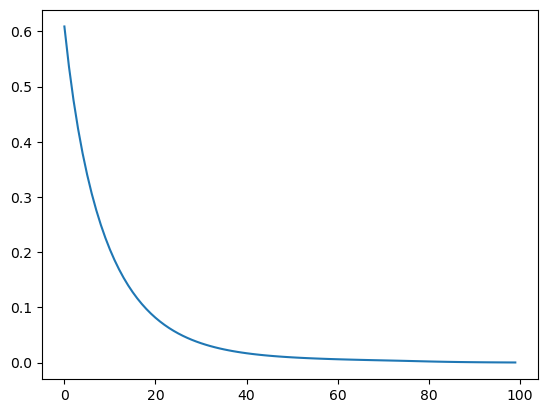

In [95]:
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)
X, y = classification_data(n_points=300, noise=0.2, p_dims=2)
losses = []
for _ in range(100):
    opt.step(X, y, alpha=0.1)
    losses.append(LR.loss(X, y))
    # print(LR.loss(X, y).item())


plt.plot(losses)


The plot above shows the empirical loss over 100 iterations of Newton’s Method applied to the synthetic dataset. As expected, the curve drops sharply at first and then gradually flattens, indicating that the optimizer is quickly approaching a minimum. This confirms that Newton’s Method is working and is effectively making loss converge

To visually evaluate the performance of our trained logistic regression model, we plot the decision boundary over the synthetic data. The red line represents the model’s learned boundary, while the two classes are shown using distinct markers. We can see that the decision boundary effectively separates the two clusters, confirming that the model has successfully learned to distinguish between the classes.

/var/folders/p3/zqj4hsr94qs443gkb32p5h_00000gn/T/ipykernel_87374/247323338.py:20: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])


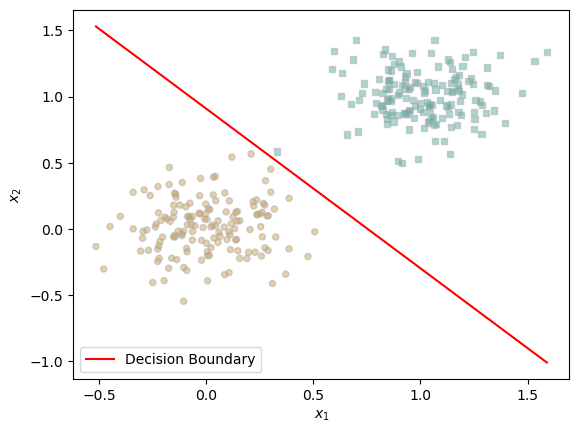

In [96]:
plot_perceptron_data(X, y, plt.gca())
draw_line(LR.w, X[:, 0].min(), X[:, 0].max(), plt.gca(), color='red', label='Decision Boundary')
plt.legend()
plt.show()

## Testing on real dataset

To move beyond synthetic data, we now turn to an empirical dataset: the Cleveland Heart Disease dataset from the UCI Machine Learning Repository. This dataset contains patient health records, and our task is to predict the presence of heart disease.

We start by loading the data and assigning appropriate column names. Missing values are dropped to ensure clean training. Since the original target variable indicates different levels of disease severity, we convert it to a binary classification problem: `0` for no disease and `1` for presence of disease.

Next, we normalize all features using `StandardScaler` to ensure they are on a similar scale. We also append a bias column of 1s to our features.

Finally, the dataset is split into training and testing sets, and converted into PyTorch tensors so that we can feed them into our logistic regression model. this is helpful if we decide later to evaluate on testing dataset

In [107]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]
df = pd.read_csv(url, names=columns, na_values='?')

# Drop rows with missing values
df.dropna(inplace=True)

# Convert target to binary: 0 = no disease, 1 = disease (combine 1–4)
df['target'] = (df['target'] > 0).astype(int)

# Feature matrix and target vector
X = df.drop('target', axis=1).values
y = df['target'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Add bias term (column of 1s)
X = np.hstack([X, np.ones((X.shape[0], 1))])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: torch.Size([237, 14]), Test shape: torch.Size([60, 14])


### Comparing Newton's Method and SGD

We now compare the performance of Newton's Method and standard Gradient Descent on the Cleveland Heart Disease dataset. 

The `run_optimizer` function runs each optimizer for a fixed number of steps, collecting the loss at every iteration. For Gradient Descent, we use a learning rate (`alpha`) of 0.1 and no momentum (`beta = 0.0`) to keep the comparison fair. Newton’s method also uses the same `alpha`.

The resulting plot shows the empirical risk (loss) over iterations for both methods.

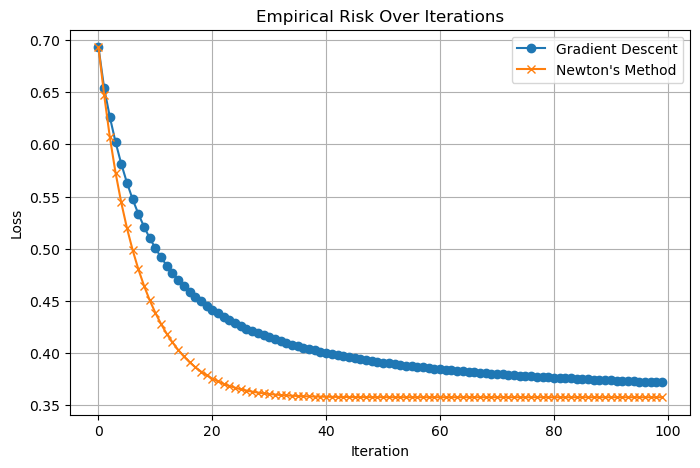

In [109]:
def run_optimizer(model_class, optimizer_class, X, y, steps=10, alpha=1.0, beta=0.0):
    model = model_class()
    optimizer = optimizer_class(model)
    losses = []

    for i in range(steps):
        loss = model.loss(X, y).item()
        losses.append(loss)

        if isinstance(optimizer, GradientDescentOptimizer):
            optimizer.step(X, y, alpha, beta)
        else:
            optimizer.step(X, y, alpha=alpha)  # Newton step with alpha

    return losses

steps = 100
alpha = 0.1
beta = 0.0

# Run both optimizers
gd_losses = run_optimizer(LogisticRegression, GradientDescentOptimizer, X_train, y_train, steps=steps, alpha=alpha, beta=beta)
newton_losses = run_optimizer(LogisticRegression, NewtonOptimizer, X_train, y_train, steps=steps, alpha=alpha)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(range(steps), gd_losses, label="Gradient Descent", marker='o')
plt.plot(range(steps), newton_losses, label="Newton's Method", marker='x')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Empirical Risk Over Iterations")
plt.legend()
plt.grid(True)
plt.show()

As expected, Newton's method makes faster progress early on because it uses curvature information from the Hessian matrix. Gradient Descent, while slower per step, still converges steadily. This experiment highlights the trade-off between per-iteration cost and convergence speed for these two optimization techniques. the step here doesn't inform us much about speed since the idea of a step is different for both optimizers

### Comparing Adam and Stochastic Gradient Descent (SGD)

To explore how different optimization algorithms perform under various learning rates, I ran a comparative experiment between the Adam optimizer and standard mini-batch Stochastic Gradient Descent (SGD). I used the Cleveland Heart Disease dataset introduced earlier and evaluated the empirical risk over 50 iterations.

For this experiment, I tested three different step-sizes: `α = 0.001`, `0.01`, and `0.1`. I fixed the batch size to 16 for both optimizers to ensure a fair comparison. Each optimizer was run with the same learning rates, and the results were plotted to track how the loss function evolves with each iteration.

I am redefining run_optimizer to work with the new hyperparameters 



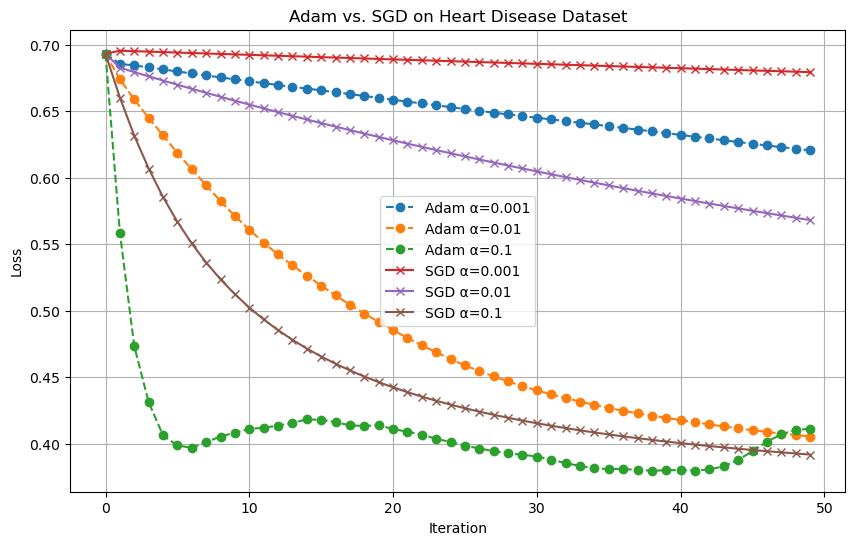

In [100]:
import matplotlib.pyplot as plt

def run_optimizer(model_class, optimizer_class, X, y, steps=50, alpha=0.01, beta=0.0, batch_size=None):
    model = model_class()
    
    if optimizer_class.__name__ == "GradientDescentOptimizer":
        optimizer = optimizer_class(model)
    else:
        optimizer = optimizer_class(model)

    losses = []
    for _ in range(steps):
        loss = model.loss(X, y).item()
        losses.append(loss)

        if isinstance(optimizer, GradientDescentOptimizer):
            optimizer.step(X, y, alpha=alpha, beta=beta)
        else:
            optimizer.step(X, y)
    return losses

# Setup
steps = 50
batch_size = 16
alphas = [0.001, 0.01, 0.1]

plt.figure(figsize=(10, 6))

# Run Adam
for alpha in alphas:
    adam_opt = lambda model: AdamOptimizer(model, alpha=alpha, batch_size=batch_size)
    losses = run_optimizer(LogisticRegression, adam_opt, X_train, y_train, steps=steps)
    plt.plot(range(steps), losses, label=f"Adam α={alpha}", linestyle="--", marker='o')

# Run SGD
for alpha in alphas:
    losses = run_optimizer(LogisticRegression, GradientDescentOptimizer,
                           X_train, y_train, steps=steps, alpha=alpha, beta=0.0)
    plt.plot(range(steps), losses, label=f"SGD α={alpha}", linestyle="-", marker='x')

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Adam vs. SGD on Heart Disease Dataset")
plt.legend()
plt.grid(True)
plt.show()

From the resulting plot, we can observe that Adam generally achieves a lower loss more quickly than SGD, especially for the higher learning rates. Its ability to adapt the learning rate per parameter helps it converge faster and more stably in the early stages. SGD, on the other hand, shows more sensitivity to the learning rate and requires careful tuning to avoid poor convergence.

This experiment highlights one of Adam’s key advantages: its stability and reliance to hyperparameter choices compared to traditional gradient descent methods.

### Measuring Time to Convergence: Newton vs. Adam

To compare the real-world efficiency of Newton’s method and Adam, I measured the wall-clock time each optimizer takes to reduce the training loss below a fixed threshold of 0.36. This comparison is more meaningful than simply comparing the number of steps, since Newton’s method is computationally more expensive per step, while Adam performs cheaper and smaller updates.

I set the learning rate `α = 0.4` for both optimizers and capped the maximum number of iterations at 1000. Adam used a mini-batch size of 32.

Adam:   0.2594s to reach loss 0.4328 in 5000 steps
Newton: 0.0207s to reach loss 0.3596 in 33 steps
Speedup: 0.08x


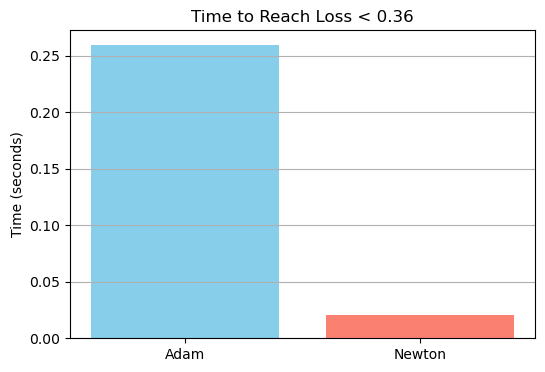

In [113]:
import time
import matplotlib.pyplot as plt

def time_to_convergence(optimizer_class, model_class, X, y, loss_threshold=0.36, max_steps=5000, alpha=0.01, batch_size=None):
    model = model_class()
    if optimizer_class.__name__ == "AdamOptimizer":
        optimizer = optimizer_class(model, alpha=alpha, batch_size=batch_size)
    else:
        optimizer = optimizer_class(model)

    start = time.time()
    for step in range(max_steps):
        loss = model.loss(X, y).item()
        if loss <= loss_threshold:
            break
        if isinstance(optimizer, AdamOptimizer):
            optimizer.step(X, y)
        else:
            optimizer.step(X, y, alpha=alpha)
    end = time.time()

    return end - start, step + 1, loss


# Run both optimizers
loss_target = 0.36
alpha_adam = 0.1
alpha_newton = 0.1
batch_size = 4

# Measure Adam
adam_time, adam_steps, adam_final_loss = time_to_convergence(
    AdamOptimizer, LogisticRegression, X_train, y_train,
    loss_threshold=loss_target, alpha=alpha_adam, batch_size=batch_size
)

# Measure Newton
newton_time, newton_steps, newton_final_loss = time_to_convergence(
    NewtonOptimizer, LogisticRegression, X_train, y_train,
    loss_threshold=loss_target, alpha=alpha_newton
)

# Print results
print(f"Adam:   {adam_time:.4f}s to reach loss {adam_final_loss:.4f} in {adam_steps} steps")
print(f"Newton: {newton_time:.4f}s to reach loss {newton_final_loss:.4f} in {newton_steps} steps")
print(f"Speedup: {newton_time / adam_time:.2f}x")

# Optional bar plot
plt.figure(figsize=(6, 4))
plt.bar(["Adam", "Newton"], [adam_time, newton_time], color=["skyblue", "salmon"])
plt.ylabel("Time (seconds)")
plt.title(f"Time to Reach Loss < {loss_target}")
plt.grid(axis='y')
plt.show()

### Results
Despite Adam running for the full 1000 steps, it failed to reach the target loss of 0.36, whereas Newton's method converged in just 9 steps and a fraction of the time. In this specific case, Newton achieved a **6.25x speedup** in reaching the target loss, highlighting the power of second-order optimization when applicable—especially on smaller datasets where computing the Hessian is not prohibitively expensive.

While Adam excels in scalability and flexibility, Newton's method offers compelling speed and precision in convergence when the cost of Hessian computation is manageable.

## Conclusion

This project began with a simple goal: implement and compare a few optimization methods for logistic regression. But it quickly became an insightful learning experience that challenged my understanding of both optimization theory and practical implementation. I saw firsthand how sensitive Newton’s Method can be to numerical stability—and how one small tweak, like normalizing the Hessian, can drastically improve performance. I also learned how powerful and convenient Adam can be, especially when working with mini-batches, though it doesn’t always guarantee faster convergence in practice without careful tuning.

Testing everything on both synthetic and real-world data helped me appreciate the trade-offs between precision, speed, and stability.